goal
+ implement some gradient flow examples
    + https://www.kernel-operations.io/geomloss/_auto_examples/index.html

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity  # display as density curves
import time

import torch
from geomloss import SamplesLoss

use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.


In [3]:
t_plot = np.linspace(-0.1, 1.1, 1000)[:, np.newaxis]


def display_samples(ax, x, color):
    """Displays samples on the unit interval using a density curve."""
    kde = KernelDensity(kernel="gaussian", bandwidth=0.005).fit(x.data.cpu().numpy())
    dens = np.exp(kde.score_samples(t_plot))
    dens[0] = 0
    dens[-1] = 0
    ax.fill(t_plot, dens, color=color)

In [5]:
N, M = (50, 50) if not use_cuda else (10000, 10000)

t_i = torch.linspace(0, 1, N).type(dtype).view(-1, 1)
t_j = torch.linspace(0, 1, M).type(dtype).view(-1, 1)

X_i, Y_j = 0.2 * t_i, 0.4 * t_j + 0.6

print(X_i.shape, Y_j.shape)

torch.Size([50, 1]) torch.Size([50, 1])


In [9]:
def gradient_flow(loss, lr=0.01):
    """Flows along the gradient of the cost function, using a simple Euler scheme.

    Parameters:
        loss ((x_i,y_j) -> torch float number):
            Real-valued loss function.
        lr (float, default = .025):
            Learning rate, i.e. time step.
    """

    # Parameters for the gradient descent
    Nsteps = int(5 / lr) + 1
    display_its = [int(t / lr) for t in [0, 0.25, 0.50, 1.0, 2.0, 5.0]]

    # Make sure that we won't modify the reference samples
    x_i, y_j = X_i.clone(), Y_j.clone()

    # We're going to perform gradient descent on Loss(α, β)
    # wrt. the positions x_i of the diracs masses that make up α:
    x_i.requires_grad = True

    t_0 = time.time()
    plt.figure(figsize=(12, 8))
    k = 1
    for i in range(Nsteps):  # Euler scheme ===============
        # Compute cost and gradient
        L_αβ = loss(x_i, y_j)
        [g] = torch.autograd.grad(L_αβ, [x_i])

        if i in display_its:  # display
            ax = plt.subplot(2, 3, k)
            k = k + 1

            display_samples(ax, y_j, (0.55, 0.55, 0.95))
            display_samples(ax, x_i, (0.95, 0.55, 0.55))

            ax.set_title("t = {:1.2f}".format(lr * i))
            plt.axis([-0.1, 1.1, -0.1, 5.5])
            plt.xticks([], [])
            plt.yticks([], [])
            plt.tight_layout()

        # in-place modification of the tensor's values
        x_i.data -= lr * len(x_i) * g
    plt.title(
        "t = {:1.2f}, elapsed time: {:.2f}s/it".format(
            lr * i, (time.time() - t_0) / Nsteps
        )
    )




In [ ]:

# def softmin_tensorized(ε, C, f):
#     B = C.shape[0]
#     return -ε * (f.view(B, 1, -1) - C / ε).logsumexp(2).view(B, -1)






In [23]:
backend='tensorized'

501


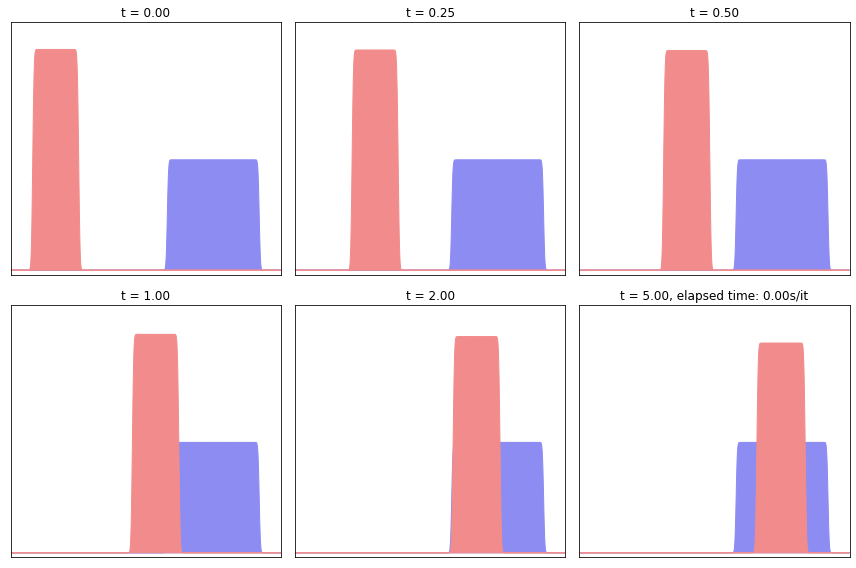

In [28]:
gradient_flow(SamplesLoss("sinkhorn", p=2, blur=1.0))


501


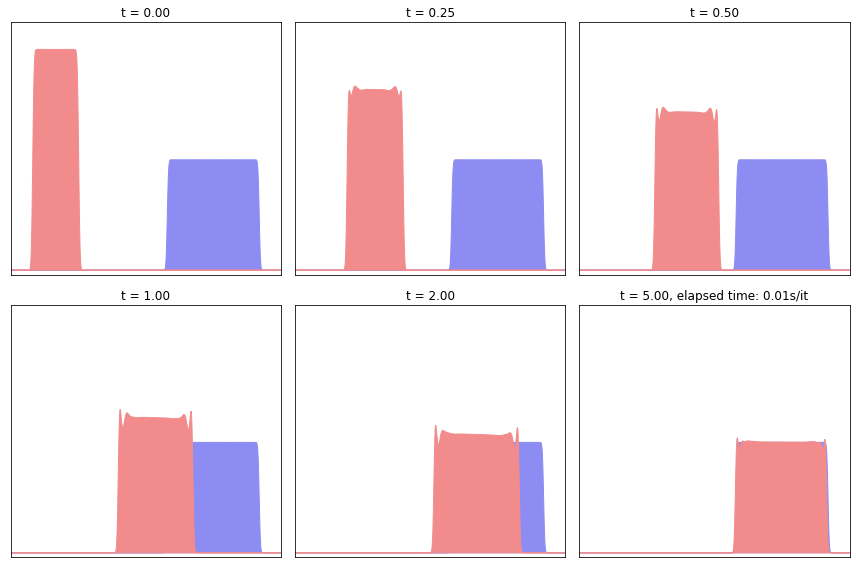

In [21]:
gradient_flow(SamplesLoss("sinkhorn", p=2, blur=0.01))


501


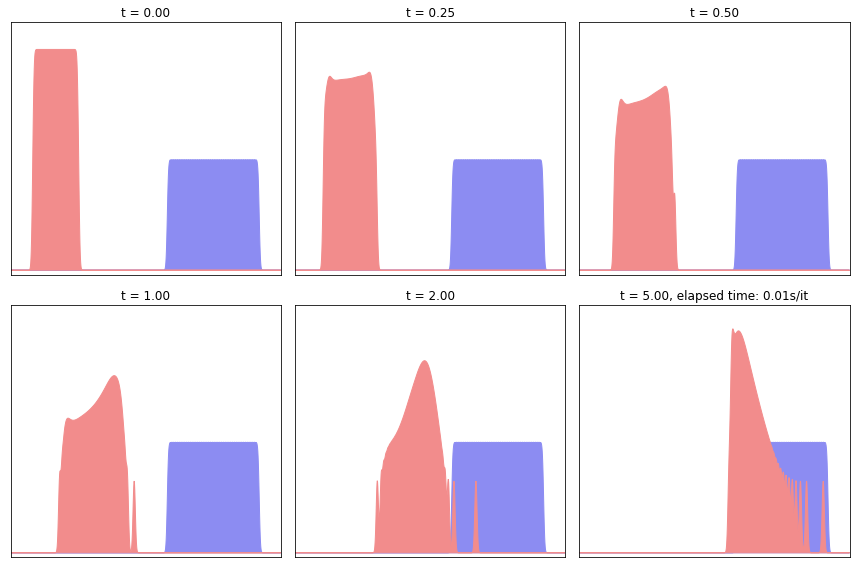

In [22]:
gradient_flow(SamplesLoss("sinkhorn", p=2, blur=0.01, reach=0.3))
